### Import

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(context='notebook', palette='Reds_r')

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, CategoricalNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from paperswithtopic.config import load_config
from paperswithtopic.preprocess import Preprocess
from paperswithtopic.run import setup
from paperswithtopic.misc import seed_everything
from paperswithtopic.mltrain import MultilabelTrainer

### Load Configuration

In [2]:
cfg = load_config()
cfg.use_saved = True
cfg.pre_embed = False
cfg.use_bert_embed = False

seed_everything(seed=cfg.seed)

### Load Data

In [3]:
X, y, _, _ = setup(cfg, debug=True)
with open(os.path.join(cfg.DATA_DIR, 'column2idx.yml'), 'r') as f:
    column2idx = yaml.load(f)
idx2column = {v: k for k, v in column2idx.items()}

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=cfg.test_size, random_state=cfg.seed)

Load tokenized, without embeddings.
[load_data] 0.1 sec 
[tokenized_pipeline] 2.9 sec 


<ipython-input-3-04f99d176403>:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  column2idx = yaml.load(f)


### Train Multiple Models

In [ ]:
MODELS = [GaussianNB, ComplementNB, LinearSVC,\
         RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,\
         LGBMClassifier, XGBClassifier, KNeighborsClassifier
     ]

trainers = dict()
for _model_class in MODELS:

    print(f'Working on {_model_class.__name__}.')
    trainer = MultilabelTrainer(cfg, _model_class, X_train, y_train, idx2column, verbose=False)
    trainer.run_all(X_test=X_test, y_test=y_test)
    trainer.plot_acc_proportion()
    trainers[_model_class.__name__] = trainer

### Aggreagate Results

In [11]:
ACC, AUC = dict(), dict()

In [12]:
for name, _trainer in trainers.items():
    
    ACC[name] = _trainer.acc
    AUC[name] = _trainer.auc

In [13]:
acc_df = pd.DataFrame(ACC)
acc_df['Chance Level'] = _trainer.chance_level.values()

<ipython-input-14-4ac37975b476>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0.0, 20.0, 40.0, 60.0, 80.0, 100.0])


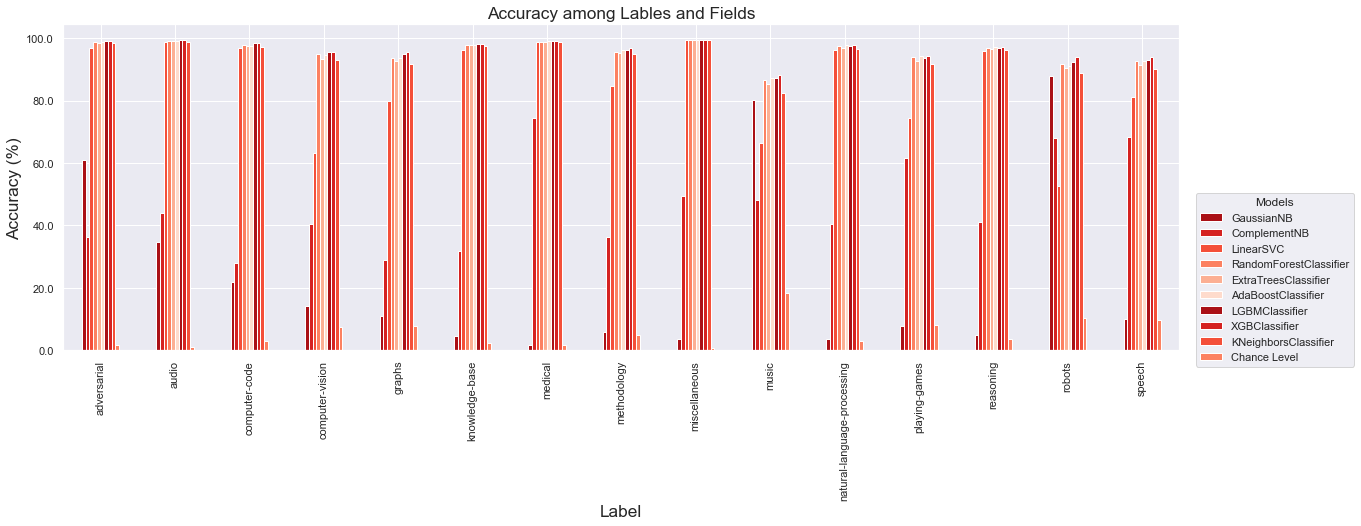

In [14]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.set_title("Accuracy among Lables and Fields", size="x-large")
ax.set_xlabel("Label", size="x-large")
ax.set_ylabel("Accuracy (%)", size="x-large")
ax.set_yticklabels([0.0, 20.0, 40.0, 60.0, 80.0, 100.0])
acc_df.plot(kind='bar', ax=ax)
ax.legend(bbox_to_anchor=(1.01, 0.5), title="Models")

<ipython-input-15-c0c72d9de711>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0.0, 20.0, 40.0, 60.0, 80.0, 100.0], size='large')


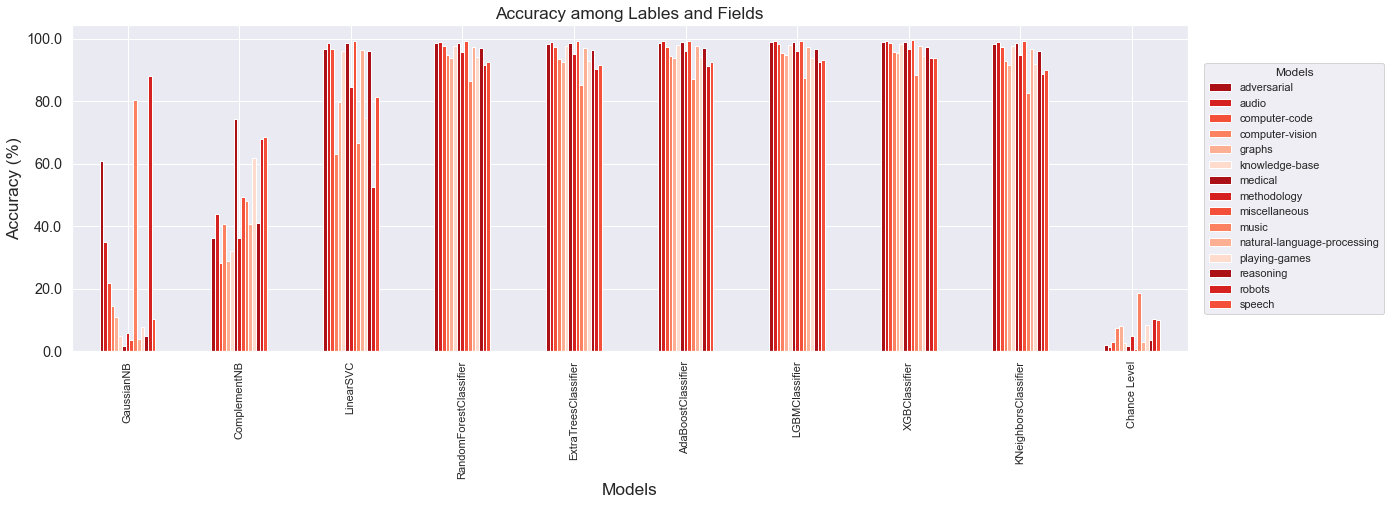

In [15]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.set_title("Accuracy among Lables and Fields", size="x-large")
ax.set_xlabel("Models", size="x-large")
ax.set_ylabel("Accuracy (%)", size="x-large")
ax.set_yticklabels([0.0, 20.0, 40.0, 60.0, 80.0, 100.0], size='large')
acc_df.T.plot(kind='bar', ax=ax)
ax.legend(bbox_to_anchor=(1.01, 0.9), title="Models")

In [16]:
auc_df = pd.DataFrame(AUC)

<ipython-input-17-1cebd3414a5a>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{0.4 + i * 0.05:.2f}' for i in range(10)], size='large')


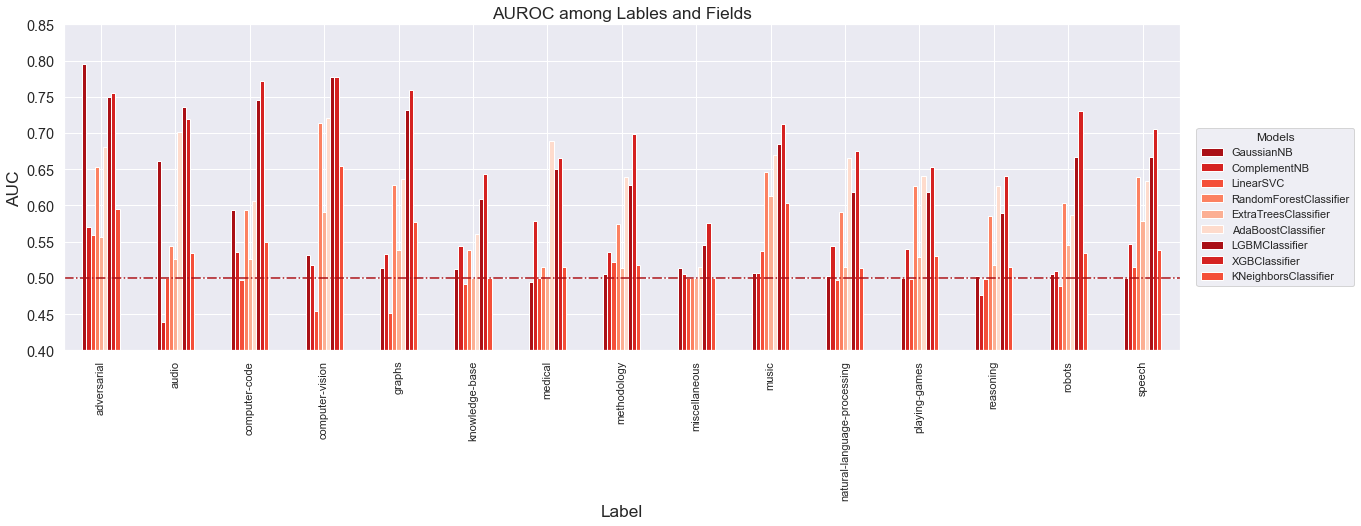

In [17]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.set_title("AUROC among Lables and Fields", size="x-large")
ax.set_xlabel("Label", size="x-large")
ax.set_ylabel("AUC", size="x-large")
ax.set_yticklabels([f'{0.4 + i * 0.05:.2f}' for i in range(10)], size='large')
ax.axhline(0.5, linestyle='-.')
ax.set_ylim(0.4, 0.85)
auc_df.plot(kind='bar', ax=ax)
ax.legend(bbox_to_anchor=(1.01, 0.7), title="Models")

<ipython-input-18-3cd77f3cc4a1>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{0.4 + i * 0.05:.2f}' for i in range(10)], size='large')


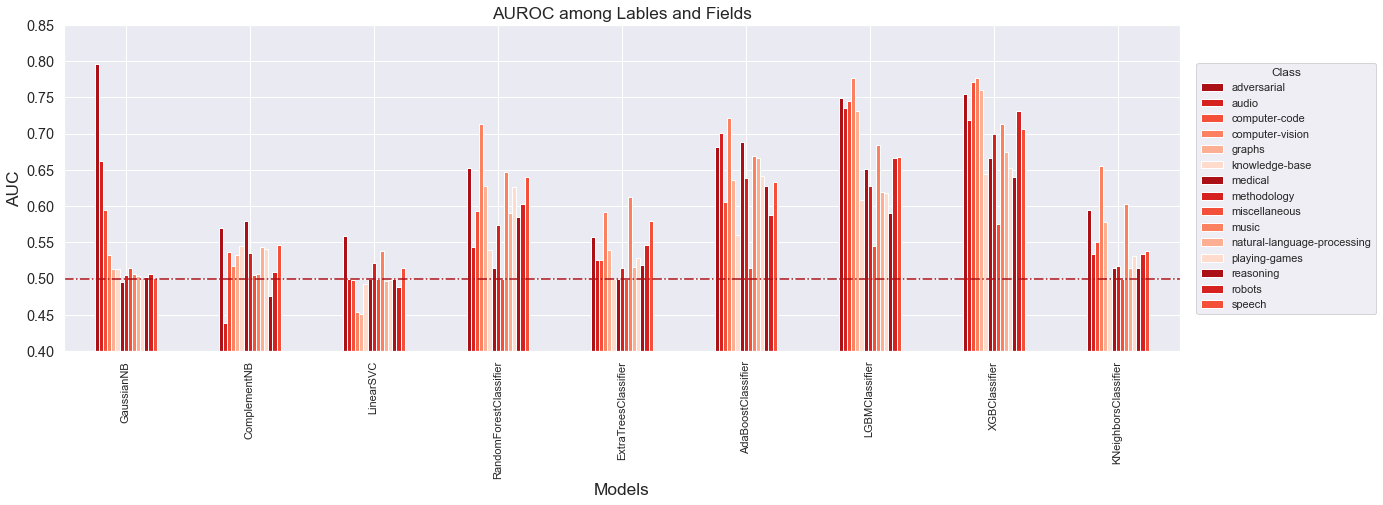

In [18]:
fig, ax = plt.subplots(figsize=(20, 6)) 
ax.set_title("AUROC among Lables and Fields", size="x-large")
ax.set_xlabel("Models", size="x-large")
ax.set_ylabel("AUC", size="x-large")
ax.tick_params(axis='x', labelrotation=45)
ax.set_yticklabels([f'{0.4 + i * 0.05:.2f}' for i in range(10)], size='large')
ax.axhline(0.5, linestyle='-.')
ax.set_ylim(0.4, 0.85)
auc_df.T.plot(kind='bar', ax=ax)
ax.legend(bbox_to_anchor=(1.01, 0.9), title="Labels")